# Background and Intro

Back in the dark ages before we had access to ChEMBL (it's hard to believe that it was only 10 years ago!) there weren't a lot of datasets available for testing/validating new computational methods. One that became something of a standard for the validation of similarity-based methods was published by Uta Lessel and Hans Briem back in 2000: [Lessel, U. F. & Briem, H. Flexsim-X:  A Method for the Detection of Molecules with Similar Biological Activity. J. Chem. Inf. Comput. Sci. 40, 246–253 (2000)](https://doi.org/10.1021/ci990439e). There's also a followup paper from later that year that uses the dataset again [Briem, H. & Lessel, U. F. In vitro and in silico affinity fingerprints: Finding similarities beyond structural classes. Perspectives in Drug Discovery and Design 20, 231–244 (2000)](https://doi.org/10.1023/A:1008793325522). This dataset was derived from the MDDR ("MACCS Drug Data Report") and included five sets of actives (ligands for particular targets) and a set of assumed inactives (compounds drawn randomly from the MDDR).

At the RDKit UGM last week Roger Sayle - another member of the RDKit community who remembers and bears the scars from the pre-ChEMBL dark ages - mentioned the Briem and Lessel dataset and used it in his [presentation about a new clustering algorithm implementation](https://github.com/rdkit/UGM_2019/raw/master/Presentations/Sayle_Clustering.pdf). I had some questions about Roger's presentation and wanted to play with the data a little bit, but I encountered a problem: licensing restrictions on the MDDR prevented Lessel and Briem from publishing the structure of the compounds they used. They did include the MDDR IDs in the supplementary material of the paper, so anyone with a copy of the MDDR could reproduce their work. (An aside: this seems pretty normal these days, but back then it wasn't all that common.)
However, I don't have an MDDR license and Roger can't legally send me the data, so there's a problem. Since we do have ChEMBL now, I decided to create a similar type of dataset that I could use to answer some questions about similarity and activity. As you might expect, this led me off on a big yak-shaving expedition, but I did get a few potentially interesting datasets along with ideas/material for some blog posts. This is the first of those.

First a word on why I didn't just use the ChEMBL datasets from either our benchmarking paper (https://doi.org/10.1186/1758-2946-5-26) or the model-fusion paper (https://doi.org/10.1021/ci400466r). The dataset from the first paper (and "datasets 1" from the second one) are derived from a publication from Heilkamp and Bajorath (https://doi.org/10.1021/ci200199u) and include "actives" for a set of targets along with assumed inactives randomly picked from ChEMBL. For those sets "active" was defined to be a potency <10uM against the target. For these new datasets I wanted to use a much stricter definition of "active".

I will do another post with a bit more detail about how I constructed the dataset (along with code), but here's a quick summary. For the purposes of this dataset I worked with ChEMBL25 and only considered Ki values (so that I can compare results between assays on the same target) and an "active" is defined to be a compound with a Ki value <= 1nM (ignoring qualified values). I then picked targets that have at least 200 "actives". This leaves me with 35 targets with between 205 and 934 "actives", listed below. For later use I also defined "inactive" for these targets to be compounds with a Ki value >= 100nM (again, ignoring qualified values). The exported dataset includes SMILES, ChEMBL IDs, active/inactive labels and measured Ki values

I also needed a set of decoys that we will assume are inactive. For this dataset I picked molecules from ChEMBL25 that have a molecular weight between 250 and 800. Since they're assumed inactives, I figured I should avoid picking anything that has actually been seen to be active in any assay, so I further filtered the set to compounds that have only been tested in a single assay. I required that the single assay be one that measures IC50 and that the measured IC50 be > 1uM. I randomly picked about 4000 molecules satisfying these criteria.

It's worth mentioning at least one other dataset of the Lessel and Briem type (it's a blog, I'm not doing a full literature survey here): a larger (11 targets instead of 5), also MDDR-based dataset, for the validation of similarity-based virtual screening methods was published by the Sheffield and Novartis groups in 2004: [Hert, J. et al. Comparison of Fingerprint-Based Methods for Virtual Screening Using Multiple Bioactive Reference Structures. Journal of Chemical Information and Modeling 44, 1177–1185 (2004)](https://doi.org/10.1021/ci034231b). That dataset was also interesting, and the paper is an absolute classic, but we're not talking about that here.

# Looking at the Lessel and Briem datasets

The goal of this exercise is to come up with something analagous to the Lessel and Briem dataset for at least some similarity comparison tests. Let's start with characterizing that data.

As I mentioned above, I don't have access to the data, but Roger agreed to run some comparisons for me and share the results with me. Here are the images along with a brief bit of description. The code to generate the images using the new dataset is below.

Let's start by creating plots similar to what Roger showed. To generate these, at each Tanimoto threshold point we look at the neighbor list for every active compound and calculate the fraction of neighbors that are from the same activity class. A "neighbor" in this context is any compound that has a similarity value to the active compound that is >= the threshold value. For the purposes of this plot, each compound is included in its own neighbor list.

Here's the plot showing the curve for each of the five targets in the B&L sets using the MFP2 fingerprint (Morgan radius 2 with default parameters) to generate similarity. The vertical black line indicates the "noise threshold" for the MFP2 fingerprint that I calculated in an [earlier blog post](https://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html).
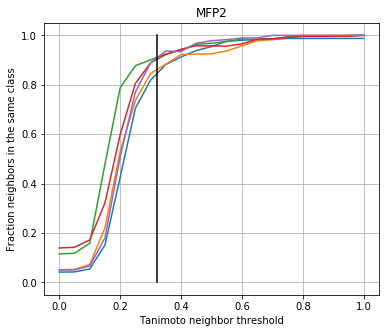
All five curves for the RDKit fingerprint (default parameters).
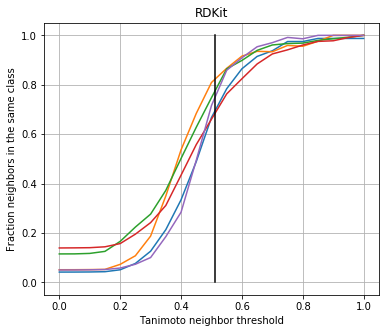

To make comparing the fingerprints easier, here's the averages of the two sets of curves:
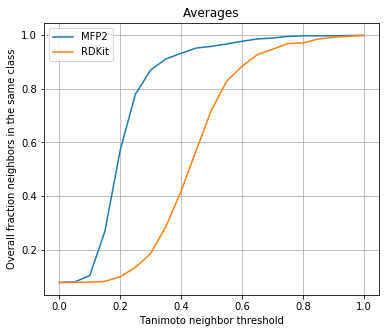

Another plot worth looking out is the in-class similarity for each class of actives:
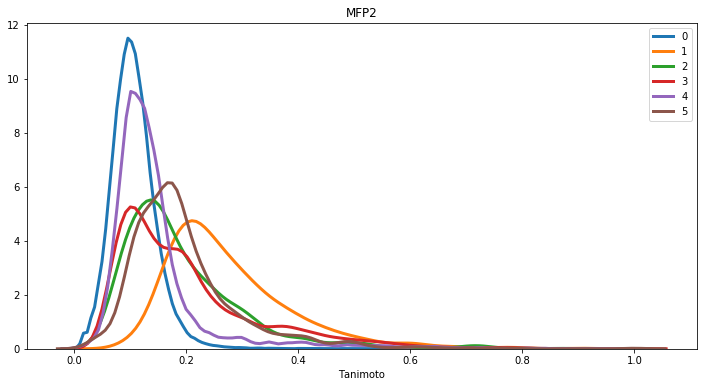
and for the RDKit fingerprint
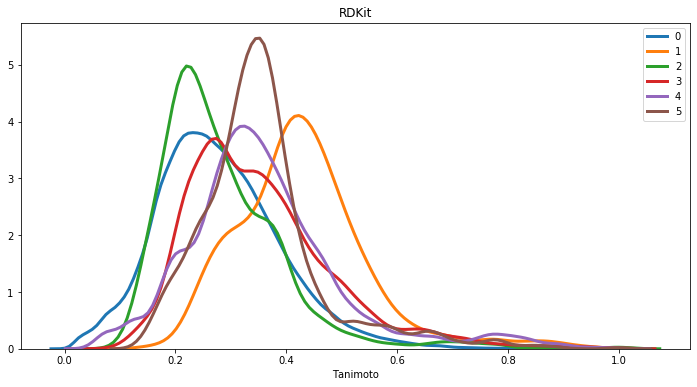
In each of these plots class 0 corresponds to the in-class similarity for the decoy set.

Unsurprisingly the RDKit fingerprints are shifted towards higher similarity values than MFP2. The RDKit fingerprint tends to have more bits set for a given molecule (I should do a blog post on that too) and the "noise threshold" is significantly higher (0.51 instead of 0.31).

What we see here more or less matches what Roger has in slides 4 and 5 of his [presentation](https://github.com/rdkit/UGM_2019/raw/master/Presentations/Sayle_Clustering.pdf), with the addition of the RDKit fingerprints. 

# Looking at the new dataset

In [1]:
import rdkit
import time
print(rdkit.__version__)
print(time.asctime())
%pylab inline

2019.03.4
Sat Oct  5 11:16:32 2019
Populating the interactive namespace from numpy and matplotlib


Metadata about the new dataset is in a separate file:

In [2]:
import pandas as pd
key_df = pd.read_csv('../data/BLSets_actives_target_key.txt',sep='\t')
key_df

,tid,chembl_id,pref_name,organism
0,8,CHEMBL1862,Tyrosine-protein kinase ABL,Homo sapiens
1,11,CHEMBL204,Thrombin,Homo sapiens
2,15,CHEMBL205,Carbonic anhydrase II,Homo sapiens
3,10260,CHEMBL4794,Vanilloid receptor,Homo sapiens
4,10280,CHEMBL264,Histamine H3 receptor,Homo sapiens
5,51,CHEMBL214,Serotonin 1a (5-HT1a) receptor,Homo sapiens
6,72,CHEMBL217,Dopamine D2 receptor,Homo sapiens
7,10841,CHEMBL4552,Peripheral-type benzodiazepine receptor,Rattus norvegicus
8,10839,CHEMBL2147,Serine/threonine-protein kinase PIM1,Homo sapiens
9,107,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens


Here's the data itself:

In [3]:
actives_df = pd.read_csv('../data/BLSets_actives.txt',sep='\t')
actives_df.head()

,smiles,target_chembl_id,label,pKi
0,Clc1ccc(cc1Cl)N2NC(=O)\C(=C\c3cccc(OCc4ccccc4)...,CHEMBL1862,inactive,6.00
1,Cc1ccc(cc1C)N2NC(=O)\C(=C\c3oc(cc3)c4ccc(C)c(C...,CHEMBL1862,inactive,5.30
2,O=C(Nc1ccccc1)Nc2nnc(Cc3ccccc3)s2,CHEMBL1862,inactive,4.24
3,Brc1cc2OCOc2cc1\C=C/3\C(=O)NN(C3=O)c4ccc(I)cc4,CHEMBL1862,inactive,5.60
4,Nc1[nH]cnc2nnc(c3ccc(Cl)cc3)c12,CHEMBL1862,inactive,6.30


Let's count the number of actives and inactives for each target:

In [4]:
nActs = []
nInacts = []
for tid in key_df.chembl_id:
    d = actives_df[actives_df.target_chembl_id == tid]
    nActs.append(len(d[d.label=='active']))
    nInacts.append(len(d[d.label=='inactive']))
key_df['nActives'] = nActs
key_df['nInactives'] = nInacts
key_df

,tid,chembl_id,pref_name,organism,nActives,nInactives
0,8,CHEMBL1862,Tyrosine-protein kinase ABL,Homo sapiens,227,205
1,11,CHEMBL204,Thrombin,Homo sapiens,452,2098
2,15,CHEMBL205,Carbonic anhydrase II,Homo sapiens,283,3094
3,10260,CHEMBL4794,Vanilloid receptor,Homo sapiens,221,86
4,10280,CHEMBL264,Histamine H3 receptor,Homo sapiens,492,527
5,51,CHEMBL214,Serotonin 1a (5-HT1a) receptor,Homo sapiens,229,1079
6,72,CHEMBL217,Dopamine D2 receptor,Homo sapiens,273,3502
7,10841,CHEMBL4552,Peripheral-type benzodiazepine receptor,Rattus norvegicus,205,188
8,10839,CHEMBL2147,Serine/threonine-protein kinase PIM1,Homo sapiens,934,133
9,107,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,290,981


In [5]:
min(nActs),max(nActs),min(nInacts),max(nInacts)

(205, 934, 54, 3502)

Read in our decoys too:

In [6]:
decoys_df = pd.read_csv('../data/BLSets_singleic50_decoys.txt',sep='\t')
decoys_df.head()

,molregno,chembl_id,smiles
0,1981,CHEMBL7027,O=C(Oc1ccc2[nH]c(cc2c1)C(=O)c3cc4ccccc4[nH]3)C...
1,2464,CHEMBL7552,OC(=O)[C@H](Cc1ccc(cc1)C#N)NC(=O)c2ccccc2Br
2,2515,CHEMBL7605,C[C@@H](NC(=O)c1ccccc1Br)C(=O)O
3,4855,CHEMBL9164,CCCCCCC(=O)O[C@H](CC=C(C)C)C1=CC(=O)c2c(O)ccc(...
4,5616,CHEMBL9455,COc1ccc(CCCN2CCC(COC(c3ccc(Cl)cc3)c4ccc(Cl)cc4...


Now lets read in all the molecules, do salt stripping, and split them into three sets: actives, measured inactives, and decoys:

In [7]:
import numpy as np
from collections import defaultdict
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.MolStandardize import rdMolStandardize
salt_remover = rdMolStandardize.FragmentRemover()

In [8]:
actives = defaultdict(list)
just_actives= actives_df[actives_df.label=='active']
for smi,tgt in zip(just_actives.smiles,just_actives.target_chembl_id):
    m = salt_remover.remove(Chem.MolFromSmiles(smi))
    Chem.SanitizeMol(m)
    actives[tgt].append(m)
inactives = defaultdict(list)
just_inactives= actives_df[actives_df.label=='inactive']
for smi,tgt in zip(just_inactives.smiles,just_inactives.target_chembl_id):
    m = salt_remover.remove(Chem.MolFromSmiles(smi))
    Chem.SanitizeMol(m)
    inactives[tgt].append(m)
decoys = []
for smi in decoys_df.smiles:
    m = salt_remover.remove(Chem.MolFromSmiles(smi))
    Chem.SanitizeMol(m)
    decoys.append(m)
    

Generate the MFP2 fingerprints using the fingerprint generator code:

In [9]:
from rdkit.Chem import rdFingerprintGenerator
mfp2_gen = rdFingerprintGenerator.GetMorganGenerator(2,useCountSimulation=False)
mfp2_fps = []
for cls in actives:
    for m in actives[cls]:
        mfp2_fps.append((cls,mfp2_gen.GetFingerprint(m)))
mfp2_inactive_fps = []
for cls in inactives:
    for m in inactives[cls]:
        mfp2_inactive_fps.append((cls,mfp2_gen.GetFingerprint(m)))
mfp2_decoys_fps = []
for m in decoys:
    mfp2_decoys_fps.append(mfp2_gen.GetFingerprint(m))

This is the code we'll use to run the actual similarity experiments.

There's ample room to make this code more readable and efficient, but for the purposes of the 

In [10]:
from collections import defaultdict
import random
def run_experiment(mols,fps,decoy_fps,decoy_frac=1.0):
    random.seed(len(fps))
    stats = defaultdict(list)
    stats_noself = defaultdict(list)
    for cls in list(mols.keys()):
        lfps = []
        for i,(cl,fp) in enumerate(fps):
            if cl != cls:
                continue
            lfps.append(fp)
        if type(decoy_fps[0])==tuple:
            decoys = [x[1] for x in decoy_fps if x[0]==cls]
        else:
            decoys = decoy_fps[:]
        random.seed(len(lfps))
        random.shuffle(decoys)
        if len(decoys)<int(decoy_frac)*len(lfps):
            print(f'skipping dataset "{cls}" for insufficient decoys')
            continue
        decoys = decoys[:int(decoy_frac*len(lfps))]
        just_classes = [cls]*len(lfps) + ['decoy']*len(decoys)
        for i,fp in enumerate(lfps):
            sims = list(zip(DataStructs.BulkTanimotoSimilarity(fp,lfps+decoys),just_classes))
            # remove the self term
            # sims.pop(i)
            sims = sorted(sims,reverse=True)
            stats[cls].append(sims)
    thresh_stats = defaultdict(lambda : defaultdict(list))
    thresh_stats_noself = defaultdict(lambda : defaultdict(list))
    for thresh in np.arange(0.0,1.05,.05):
        tkey='%.2f'%thresh
        for cls in stats:
            for ex in stats[cls]:
                consider = [x for x in ex if x[0]>=thresh]
                if not len(consider):
                    pass
                else:
                    ncorrect = len([1 for x,y in consider if y==cls])
                    thresh_stats[tkey][cls].append(ncorrect/len(consider))
                    if len(consider)>1:
                        thresh_stats_noself[tkey][cls].append((ncorrect-1)/(len(consider)-1))
    cls_means = defaultdict(list)
    cls_means_noself = defaultdict(list)
       
    for thresh in thresh_stats:
        vaccum = []
        for cls in thresh_stats[thresh]:
            v = np.mean(thresh_stats[thresh][cls])
            vaccum.append(v)
            cls_means[cls].append((float(thresh),v))
        cls_means['overall'].append((float(thresh),np.mean(vaccum)))
        for cls in thresh_stats_noself[thresh]:
            cls_means_noself[cls].append((float(thresh),np.mean(thresh_stats_noself[thresh][cls])))    
    return cls_means,cls_means_noself

In [11]:
mfp2_cls_means,mfp2_cls_means_noself = run_experiment(actives,mfp2_fps,mfp2_decoys_fps,decoy_frac=2)

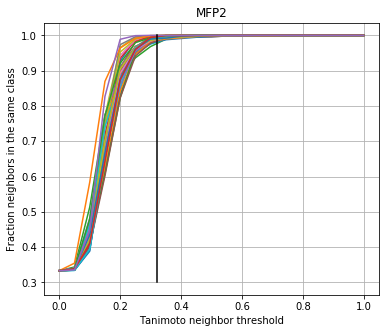

In [12]:
figsize(6,5)
for cls in mfp2_cls_means:
    if cls=='overall': continue
    plot([x for x,y in mfp2_cls_means[cls]],[y for x,y in mfp2_cls_means[cls]],'-');
plot([0.32,0.32],[0.3,1.0],'k-')
xlabel('Tanimoto neighbor threshold');
ylabel('Fraction neighbors in the same class');
title('MFP2')
grid();

The curves all start at 0.33 since we have constructed the sets we look at to have 1/3 active, 2/3 decoys.

Repeat that for the RDKit fingerprint:

In [13]:
rdk_fps = []
for cls in actives:
    for m in actives[cls]:
        rdk_fps.append((cls,Chem.RDKFingerprint(m)))
rdk_inactive_fps = []
for cls in inactives:
    for m in inactives[cls]:
        rdk_inactive_fps.append((cls,Chem.RDKFingerprint(m)))
rdk_decoys_fps = []
for m in decoys:
    rdk_decoys_fps.append(Chem.RDKFingerprint(m))

In [14]:
rdk_cls_means,rdk_cls_means_noself = run_experiment(actives,rdk_fps,rdk_decoys_fps,decoy_frac=2)

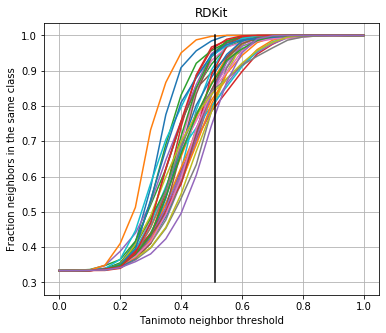

In [15]:
figsize(6,5)
for cls in rdk_cls_means:
    if cls=='overall': continue
    plot([x for x,y in rdk_cls_means[cls]],[y for x,y in rdk_cls_means[cls]],'-');
plot([0.51,0.51],[0.3,1.0],'k-')
xlabel('Tanimoto neighbor threshold');
ylabel('Fraction neighbors in the same class');
title('RDKit')
grid();

And now let's compare the average values using the two different fingerprints:

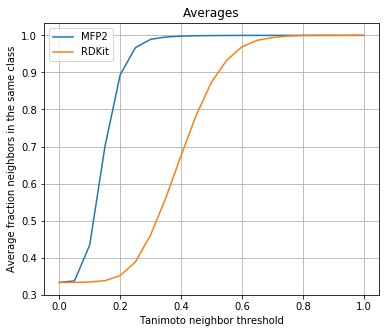

In [16]:
figsize(6,5)
cls = 'overall'
plot([x for x,y in mfp2_cls_means[cls]],[y for x,y in mfp2_cls_means[cls]],'-',label='MFP2');
plot([x for x,y in rdk_cls_means[cls]],[y for x,y in rdk_cls_means[cls]],'-',label="RDKit");
xlabel('Tanimoto neighbor threshold');
ylabel('Average fraction neighbors in the same class');
title('Averages')
legend();
grid();

This looks somewhat similar to what we saw for the original Lessel and Briem datasets, but it's definitely shifted to higher accuracy.

# Similarity distributions within the sets of actives

It's also good to look at the in-class similarity for the sets of actives and within the decoys, as I showed for the Lessel and Briem sets above.

In [17]:
self_sims_mfp2 = defaultdict(list)
for cls in actives.keys():
    lfps = [y for x,y in mfp2_fps if x==cls]
    for i,fp in enumerate(lfps):
        self_sims_mfp2[cls].extend(DataStructs.BulkTanimotoSimilarity(fp,lfps[i+1:]))
decoy_sims_mfp2 = []
for i,fp in enumerate(mfp2_decoys_fps):
    decoy_sims_mfp2.extend(DataStructs.BulkTanimotoSimilarity(fp,mfp2_decoys_fps[i+1:]))

In [18]:
import seaborn as sns

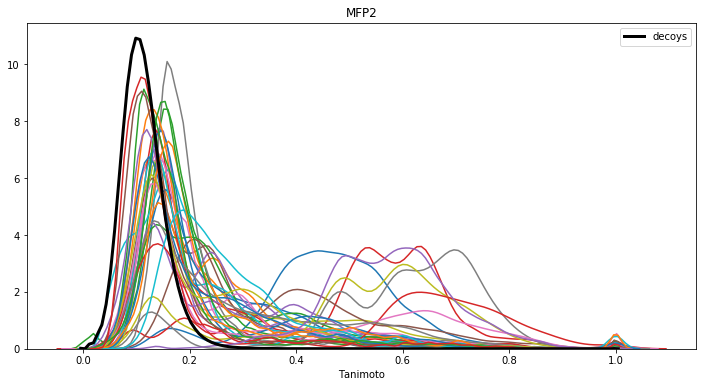

In [19]:
figsize(12,6)
for dkey,dset in self_sims_mfp2.items():
    sns.distplot(dset,hist=False)
sns.distplot(decoy_sims_mfp2,hist=False,kde_kws={"lw":3, "color":"k"},label='decoys')
title('MFP2');
xlabel('Tanimoto');

The thick black line shows the distribution for the decoy set.

In [20]:
self_sims_rdk = defaultdict(list)
for cls in actives.keys():
    lfps = [y for x,y in rdk_fps if x==cls]
    for i,fp in enumerate(lfps):
        self_sims_rdk[cls].extend(DataStructs.BulkTanimotoSimilarity(fp,lfps[i+1:]))
decoy_sims_rdk = []
for i,fp in enumerate(rdk_decoys_fps):
    decoy_sims_rdk.extend(DataStructs.BulkTanimotoSimilarity(fp,rdk_decoys_fps[i+1:]))

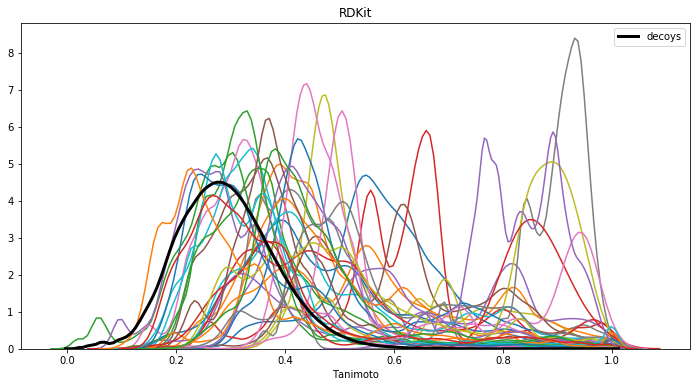

In [21]:
figsize(12,6)
for dkey,dset in self_sims_rdk.items():
    sns.distplot(dset,hist=False)
sns.distplot(decoy_sims_rdk,hist=False,kde_kws={"lw":3, "color":"k"},label='decoys')
title('RDKit');
xlabel('Tanimoto');

The thick black line shows the distribution for the decoy set.

Comparing these plots with the ones for the Lessel and Briem dataset above shows that some of our new classes have in-class similarities that are much higher. This is definitely a qualitative difference and something I'd like to avoid. 

Let's look at the calculated means of the in-class similarities and compare them to those for the Lessel and Briem datasets:

In [22]:
BL_accum = {'dset': [0, 1, 2, 3, 4, 5], 'rdk_mean': [0.2788683553454373, 0.42877091013309626, 0.2830092422730135, 0.3528721259998584, 0.35858049802928454, 0.3553779251711522], 'rdk_dev': [0.11152275504627157, 0.11963766429723, 0.11100832907263279, 0.1316513552583086, 0.14192829801574408, 0.11393433861758107], 'mfp2_mean': [0.10652411196480265, 0.2753532690616291, 0.19131810923782575, 0.19904212492145634, 0.14704942387901174, 0.19547168099721157], 'mfp2_dev': [0.04193685663319514, 0.11248484081722564, 0.10949593291412174, 0.12667367712154293, 0.0975286356144794, 0.09951581334139196]}
BL_accum = pd.DataFrame(BL_accum)
BL_accum.sort_values('rdk_mean',ascending=False)


,dset,rdk_mean,rdk_dev,mfp2_mean,mfp2_dev
1,1,0.428771,0.119638,0.275353,0.112485
4,4,0.358580,0.141928,0.147049,0.097529
5,5,0.355378,0.113934,0.195472,0.099516
3,3,0.352872,0.131651,0.199042,0.126674
2,2,0.283009,0.111008,0.191318,0.109496
0,0,0.278868,0.111523,0.106524,0.041937


In [23]:
accum = defaultdict(list)
for dkey,dset_rdk in list(self_sims_rdk.items()):
    dset_mfp2 = self_sims_mfp2[dkey]
    accum['dset'].append(dkey)
    accum['rdk_mean'].append(np.average(dset_rdk))
    accum['rdk_dev'].append(np.std(dset_rdk))
    accum['mfp2_mean'].append(np.average(dset_mfp2))
    accum['mfp2_dev'].append(np.std(dset_mfp2))
accum = pd.DataFrame(accum)
accum.sort_values('rdk_mean',ascending=False)


,dset,rdk_mean,rdk_dev,mfp2_mean,mfp2_dev
17,CHEMBL2835,0.840702,0.163180,0.578289,0.183538
34,CHEMBL4860,0.829574,0.080468,0.574694,0.118133
18,CHEMBL2971,0.781999,0.174628,0.500042,0.198064
26,CHEMBL256,0.664803,0.199639,0.347804,0.250635
23,CHEMBL245,0.620668,0.261534,0.442913,0.282850
15,CHEMBL2366517,0.610666,0.152335,0.370330,0.184108
3,CHEMBL4794,0.609035,0.152156,0.525308,0.178412
14,CHEMBL237,0.587146,0.212812,0.279306,0.162626
0,CHEMBL1862,0.580295,0.112744,0.459660,0.127287
8,CHEMBL2147,0.572497,0.146550,0.278098,0.175450


Let's filter to only include sets where the mean rdkit similarity is <0.5:

In [24]:
filtered_sets = list(accum[accum.rdk_mean<0.5]['dset'])
print(filtered_sets)
len(filtered_sets)

['CHEMBL204', 'CHEMBL205', 'CHEMBL264', 'CHEMBL214', 'CHEMBL217', 'CHEMBL4552', 'CHEMBL224', 'CHEMBL229', 'CHEMBL234', 'CHEMBL244', 'CHEMBL339', 'CHEMBL251', 'CHEMBL253', 'CHEMBL270', 'CHEMBL1946', 'CHEMBL273', 'CHEMBL1907596', 'CHEMBL3371', 'CHEMBL313']


19

Look at the cumulative distributions

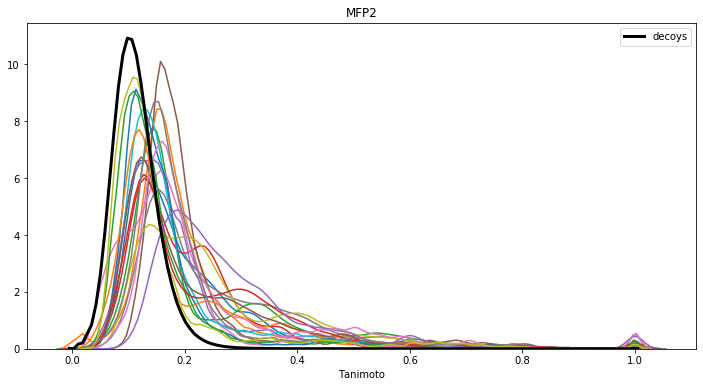

In [25]:
figsize(12,6)
for dkey in filtered_sets:
    dset = self_sims_mfp2[dkey]
    sns.distplot(dset,hist=False)
sns.distplot(decoy_sims_mfp2,hist=False,kde_kws={"lw":3, "color":"k"},label='decoys')
title('MFP2');
xlabel('Tanimoto');

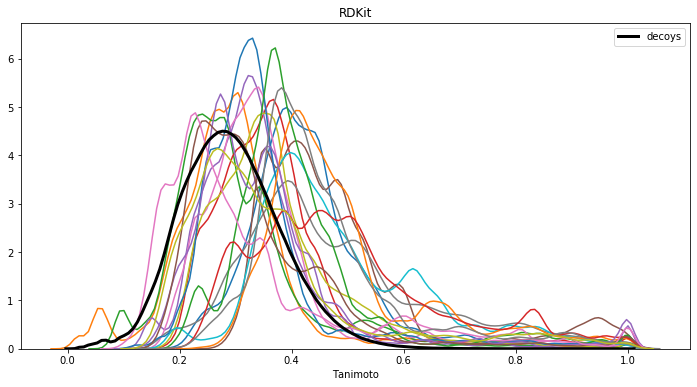

In [26]:
figsize(12,6)
for dkey in filtered_sets:
    dset = self_sims_rdk[dkey]
    sns.distplot(dset,hist=False)
sns.distplot(decoy_sims_rdk,hist=False,kde_kws={"lw":3, "color":"k"},label='decoys')
title('RDKit');
xlabel('Tanimoto');

That looks a lot better. Let's try the other plots again:

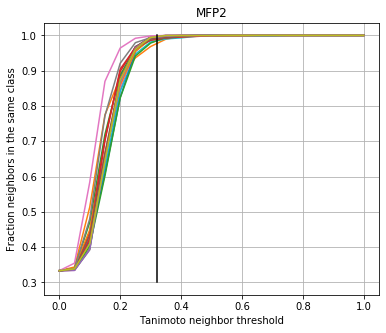

In [27]:
figsize(6,5)
for cls in filtered_sets:
    if cls=='overall': continue
    plot([x for x,y in mfp2_cls_means[cls]],[y for x,y in mfp2_cls_means[cls]],'-');
plot([0.32,0.32],[0.3,1.0],'k-')
xlabel('Tanimoto neighbor threshold');
ylabel('Fraction neighbors in the same class');
title('MFP2')
grid();

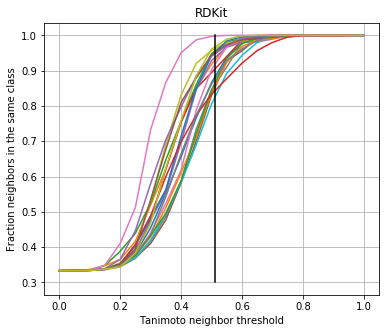

In [28]:
figsize(6,5)
for cls in filtered_sets:
    if cls=='overall': continue
    plot([x for x,y in rdk_cls_means[cls]],[y for x,y in rdk_cls_means[cls]],'-');
plot([0.51,0.51],[0.3,1.0],'k-')
xlabel('Tanimoto neighbor threshold');
ylabel('Fraction neighbors in the same class');
title('RDKit')
grid();

These are still shifted quite a bit further to the left than the plots for the original data. This is very likely due to the differences in the way decoys are used in the two experiments.

For now, let's take a look at the targets that have survived the analysis:

In [31]:
sel_df = key_df[key_df.chembl_id.isin(filtered_sets)]
sel_df

,tid,chembl_id,pref_name,organism,nActives,nInactives
1,11,CHEMBL204,Thrombin,Homo sapiens,452,2098
2,15,CHEMBL205,Carbonic anhydrase II,Homo sapiens,283,3094
4,10280,CHEMBL264,Histamine H3 receptor,Homo sapiens,492,527
5,51,CHEMBL214,Serotonin 1a (5-HT1a) receptor,Homo sapiens,229,1079
6,72,CHEMBL217,Dopamine D2 receptor,Homo sapiens,273,3502
7,10841,CHEMBL4552,Peripheral-type benzodiazepine receptor,Rattus norvegicus,205,188
9,107,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,290,981
10,125,CHEMBL229,Alpha-1a adrenergic receptor,Homo sapiens,250,154
12,130,CHEMBL234,Dopamine D3 receptor,Homo sapiens,373,1369
21,194,CHEMBL244,Coagulation factor X,Homo sapiens,637,1752


And let's write the actives from those sets out to a file so that it's easy for others to use them later. The decoys are in the decoys file `../data/BLSets_singleic50_decoys.txt`.

The data, as well as this notebook, are all in the github repo for this blog: https://github.com/greglandrum/rdkit_blog


In [33]:
clsDict = dict(zip(sel_df.chembl_id,range(len(sel_df))))
with open('../data/BLSets_selected_actives.txt','w+') as outf:
    print('smiles target_chembl_id target_index',file=outf)
    for smiles,cid in zip(just_actives.smiles,just_actives.target_chembl_id):
        if cid not in filtered_sets:
            continue
        print(smiles,cid,clsDict[cid],file=outf)

Many thanks to Roger for the inspiration for this, generating the data on the original dataset, and for an email discussion as I was putting this together.